In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ploting graphs
import collections #dictionary
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')
STOP_WORDS = set(stopwords.words('english'))


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train_df=pd.read_csv(r'../input/train.csv')

In [3]:
train_df.head()

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.30,Froud app i recharge 199 but not done also sen...,NaN,1
2,93ff57f7-9e02-4fa9-b779-3db82b8af0a4,52.0,2.12,Waste to write comments also,Waste no use,2
3,df2dcdef-c09a-4f35-afab-e1231d3fec9a,62.0,2.21,Nice apo,NaN,5
4,11f8f968-4cec-4424-8427-9709ab05b5be,69.0,2.28,Good nice app,NaN,5


In [4]:
test_df=pd.read_csv(r'../input/test.csv')

In [5]:
test_df.head()

,id,App Version Code,App Version Name,Review Text,Review Title
0,bdcb3129-afc1-4608-825f-558fe9c17e2b,78.0,2.37,"Awesome app, all should use it",NaN
1,7518d5c8-5e35-45e2-b29d-cf0996ba9e2f,75.0,2.34,how can i stop notification,NaN
2,b21ca913-ba44-471b-91e1-aaf035379a84,NaN,NaN,"This app is very easy to use , nice graphics ,...",NaN
3,beaaa17d-44af-44c8-ba38-24ba54c3b17d,83.0,2.42,Quite good but felt slow response from cc. Ove...,NaN
4,89d8c4f0-6fe0-4389-b1f8-913ba894c0f1,74.0,2.33,Not getting otp for login since yesterday. Als...,NaN


In [6]:
# shape of train_df
train_df.shape

(5693, 6)

In [7]:
# shape of test_df
test_df.shape

(1424, 5)

**Checking for any missing values**

In [8]:
train_df.isnull().sum()

id                     0
App Version Code    1139
App Version Name    1139
Review Text            1
Review Title        5091
Star Rating            0
dtype: int64

In [9]:
test_df.isnull().sum()

id                     0
App Version Code     273
App Version Name     273
Review Text            1
Review Title        1244
dtype: int64

In [10]:
# review title seems to be of no use as it has close to 90% values missing, 
# so getting rid of it makes sense
train_df.drop(['Review Title'],axis=1,inplace = True)
test_df.drop(['Review Title'],axis=1,inplace = True)




In [11]:
# checking unique values of train_df
for col in train_df.columns:
    print('{} : {}'.format(col,len(train_df[col].unique())))

id : 5693
App Version Code : 64
App Version Name : 56
Review Text : 4570
Star Rating : 5


In [12]:
# checking unique values of test_df
for col in test_df.columns:
    print('{} : {}'.format(col,len(train_df[col].unique())))

id : 5693
App Version Code : 64
App Version Name : 56
Review Text : 4570


In [13]:
# exploring the rating column of train_df
train_df['Star Rating'].describe()

count    5693.000000
mean        3.479009
std         1.793187
min         1.000000
25%         1.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Star Rating, dtype: float64

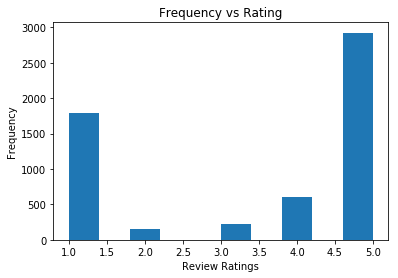

In [14]:
# plotting the histogram of rating column
plt.hist(train_df['Star Rating'])
plt.xlabel('Review Ratings')
plt.ylabel('Frequency')
plt.title('Frequency vs Rating')
plt.show()


**this dataset clearly suffers from class imbalance problem, also indicates the 
customers are either too satisfied or too disappointed**

In [15]:
# exploring the app version code with rating
train_app_df = train_df.groupby('App Version Code')
train_app_df = train_app_df.agg('mean')


In [16]:
# app versions with top rating
train_app_df = train_app_df.reset_index().drop('App Version Name',axis=1)
train_app_df.head()

,App Version Code,Star Rating
0,1.0,4.750000
1,2.0,3.800000
2,9.0,4.333333
3,10.0,3.833333
4,11.0,3.238095


In [17]:
# top 10 app versions with best mean star rating
train_app_df.sort_values('Star Rating',inplace = True)
print(train_app_df['App Version Code'].iloc[-9:])

8     18.0
0      1.0
14    34.0
5     13.0
6     14.0
7     17.0
10    29.0
45    72.0
13    33.0
Name: App Version Code, dtype: float64


In [18]:
# top 10 app versions with worst mean star rating
print(train_app_df['App Version Code'].iloc[:9])

21    42.0
20    40.0
18    38.0
24    45.0
22    43.0
9     28.0
15    35.0
25    46.0
32    56.0
Name: App Version Code, dtype: float64


In [19]:
# exploring the text of top 10 best app versions excluding the stop words
def common_words_extractor(text_list):
    words_counter = collections.Counter([word.lower() for sentence in text_list for word in sentence.split() if word not in STOP_WORDS])
    print('10 Most common words in the text are:')
    print('"' + '" "'.join(list(zip(*words_counter.most_common(10)))[0]) + '"')

best_text_list=train_df[train_df['App Version Code'].isin(train_app_df['App Version Code'].iloc[-9:])]['Review Text']
common_words_extractor(best_text_list)

10 Most common words in the text are:
"app" "i" "really" "would" "services" "great" "works" ":)" "going" "good"


In [20]:
# exploring the text of top 10 worst app versions excluding the stop words
STOP_WORDS.add('.')
worst_text_list=train_df[train_df['App Version Code'].isin(train_app_df['App Version Code'].iloc[:9])]['Review Text']
common_words_extractor(worst_text_list)

10 Most common words in the text are:
"app" "i" "recharge" "niki" "bill" "use" "get" "payment" "money" "good"


**Perhaps the problem with worst performing app versions was while payments and money lost**

**Let's dig deeper into the whole review text**

In [21]:
# total unique words in the text
text_list=train_df[train_df['Review Text'].notnull()]['Review Text']
unique_words_counter = collections.Counter([word.lower() for sentence in text_list for word in sentence.split()])
print('total unique words in the text are : {}'.format(len(unique_words_counter)))


total unique words in the text are : 8305


In [22]:
text_lengths = [len(i) for i in text_list]
print('max length of the reviews: {}'.format(max(text_lengths)))
print('min length of the reviews: {}'.format(min(text_lengths)))

max length of the reviews: 1816
min length of the reviews: 1


In [23]:
# common words in the whole review text column
common_words_extractor(train_df[train_df['Review Text'].notnull()]['Review Text'])

10 Most common words in the text are:
"app" "i" "good" "recharge" "nice" "bill" "use" "niki" "payment" "very"


In [24]:
def generate_word_cloud(text_series):
    text_corpus=''
    for sentence in text_series:
        for word in sentence.split():
            text_corpus = text_corpus + ' ' + word.lower()
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', 
                    stopwords = STOP_WORDS,
                    min_font_size = 10).generate(text_corpus)
    #print(text_corpus)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

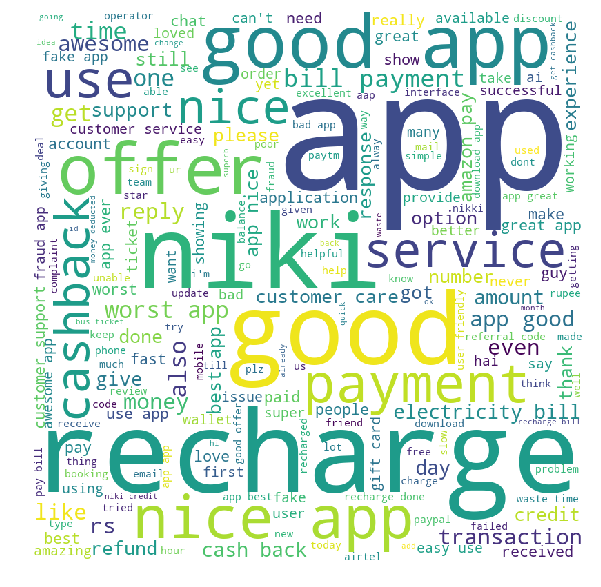

In [25]:
#word cloud of the whole text
generate_word_cloud(train_df[train_df['Review Text'].notnull()]['Review Text'])

**Overall the sentiment seems to be positive, as most of the reviews have positive words like good,nice,awesome. The customers seem to love the cashback offers which is obvious.**

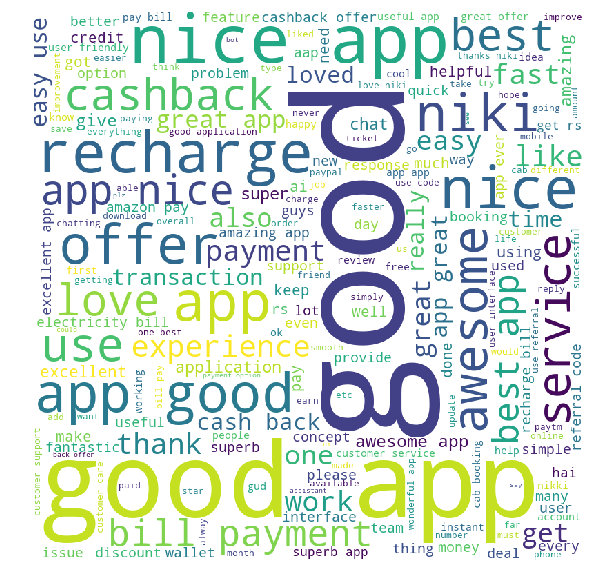

In [26]:
# word cloud of text with positive reviews(I am considering reviews with ratings 5 & 4 as positive reviews)
train_positive_df=train_df[train_df['Star Rating'].notnull()]
train_positive_df = train_positive_df[train_positive_df['Star Rating']>=4]
generate_word_cloud(train_positive_df['Review Text'])

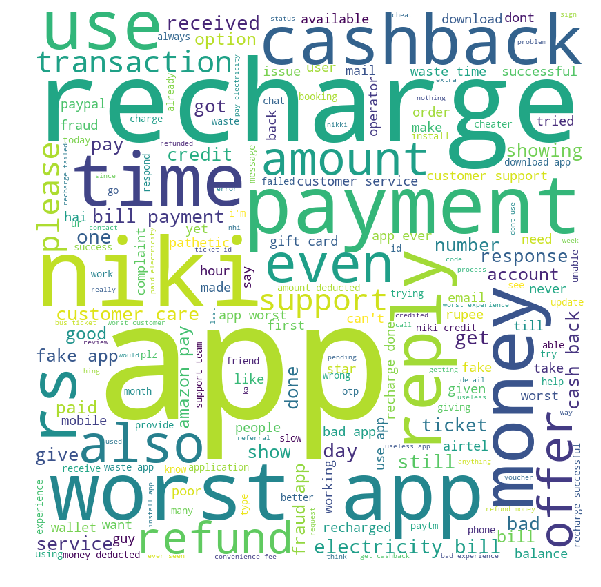

In [27]:
# word cloud of text with negative reviews(I am considering reviews with ratings 1 & 2 as negative reviews)
train_negative_df=train_df[train_df['Star Rating'].notnull()]
train_negative_df = train_negative_df[train_negative_df['Star Rating']<=2]
generate_word_cloud(train_negative_df['Review Text'])

**problems with transaction failure seems to be a factor for indignant feeling among the customers**

In [28]:
train_df.drop(['id','App Version Name'],axis=1,inplace=True)
train_df.head()

,App Version Code,Review Text,Star Rating
0,NaN,Very bad wallet balance not use.,1
1,43.0,Froud app i recharge 199 but not done also sen...,1
2,52.0,Waste to write comments also,2
3,62.0,Nice apo,5
4,69.0,Good nice app,5


**Classification:**

**Since the data set is relatively small(5k Rows). I think the bag of words model would be suitable for our classification.And the data has lot of indian words in the review text hence I do not prefer using a model with pretrained embedding vectors or a neural network.Anyway I will try both the models just to be sure**

**Feature extraction: I am going to convert the text to lowercase first, then use "treebankwordtokenizer" which is good at tokenizing sentences with punctuations very well.Then convert the text to tfidf features(leaving app version code).Also normalize the app version code feature**

In [29]:
def tokenizer(text):
    if text != '':
        text=text.lower()
        tokenized_text = ' '.join(TreebankWordTokenizer().tokenize(text))
        return tokenized_text
    return ''

**Splitting the train data into train and validation sets**

In [30]:
X_train_df, X_val_df, Y_train, Y_val = train_test_split(train_df.iloc[:,0:2], train_df['Star Rating'], test_size=0.2, random_state=0,)

In [31]:
vectorizer = TfidfVectorizer()
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
scaler = StandardScaler()
def train_feature_extractor(X_train,tfidf):
    X_train['Review Text'] = X_train['Review Text'].fillna('')
    X_train['Review Text'] = X_train['Review Text'].apply(tokenizer)
    X = tfidf.fit_transform(X_train['Review Text'])
    app_version_matrix = imp_mode.fit_transform(X_train['App Version Code'].as_matrix().reshape(-1,1))
    app_version_matrix = scaler.fit_transform(app_version_matrix)
    X = np.concatenate((X.toarray(),app_version_matrix),axis=1)
    return X

def test_feature_extractor(X_val,tfidf):
    X_val['Review Text'] = X_val['Review Text'].fillna('')
    X_val['Review Text'] = X_val['Review Text'].apply(tokenizer)
    X = tfidf.transform(X_val['Review Text'])
    app_version_matrix = imp_mode.transform(X_val['App Version Code'].as_matrix().reshape(-1,1))
    app_version_matrix = scaler.transform(app_version_matrix)
    X = np.concatenate((X.toarray(),app_version_matrix),axis=1)
    return X
X_train=train_feature_extractor(X_train_df,vectorizer)
X_val=test_feature_extractor(X_val_df,vectorizer)
    

**Logistic regression model**

In [32]:
clf_lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, Y_train)
print('logistic regression')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_lr.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_lr.predict(X_val), average='weighted')))

logistic regression
training weighted fscore: 0.7551390279154863
test weighted fscore: 0.7166822050355701


**SVM model(linear kernel)**

In [33]:
clf_svm = LinearSVC(random_state=0, tol=1e-5,multi_class='ovr').fit(X_train, Y_train)
print('SVM')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_svm.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_svm.predict(X_val), average='weighted')))

SVM
training weighted fscore: 0.8960362501351142
test weighted fscore: 0.72710533172416


**K nearest neighbor**

In [34]:
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)
print('knn')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_knn.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_knn.predict(X_val), average='weighted')))

knn
training weighted fscore: 0.7032481534958638
test weighted fscore: 0.5493817797220458


**Gaussian Naive Bayes classifier**

In [35]:
clf_gnb = GaussianNB().fit(X_train, Y_train)
print('gnb')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_gnb.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_gnb.predict(X_val), average='weighted')))


gnb
training weighted fscore: 0.5956472172397284
test weighted fscore: 0.36186185129417814


**SVM (linear kernel,one vs all)**

In [ ]:
clf_svmg = OneVsRestClassifier(SVC(kernel='linear',probability=True)).fit(X_train,Y_train)
print('svm gaussian')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_svmg.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_svmg.predict(X_val), average='weighted')))

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=500,random_state=0).fit(X_train,Y_train)
print('randome forest')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_rf.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_rf.predict(X_val), average='weighted')))

**SVM(linear) model works best among the classifiers, so i will focus more on SVM**

In [36]:
# checking the examples which the svm classifier failed to classify correctly
def failed_examples(predictions):
    check = np.equal(Y_val,predictions,dtype=int)
    ind = np.where(check == 0)
    ind = list(ind[0])
    X_temp = X_val_df.reset_index(drop=True)
    fail_df = X_temp[X_temp.index.isin(ind)]
    Y_temp = Y_val.reset_index(drop=True)
    fail_rating = Y_temp[Y_temp.index.isin(ind)]
    fail_df['Star Rating'] = fail_rating
    print(predictions[ind].shape)
    fail_df['Predicted Star Rating'] = predictions[ind]
    return fail_df.reset_index(drop=True)

In [37]:
df=failed_examples(clf_svm.predict(X_val))

(253,)


**Exploring some of the failed example's review text: **

In [38]:
print(list(df[(df['Star Rating']==1) & (df['Predicted Star Rating']==5)]['Review Text']))

['feku', 'after watching below comments.. i declined to install this app .', 'expected more .', 'iam expect 140 cash back', 'hopeless app. the interface is fine but credits or cashback are retained by app itself .', 'need to improve more', 'fraudulent', 'very good app for recharge and bill pay', 'thought of trying out niki to pay bills.. thought it would be fast ... but guess what niki just kept typing whole sunday afternoon ... sometimes it gave me the menu options again and again ... quite disappointing..', 'use mat karo 👎👎👎', 'please add gescom in electricity bill payments', 'bkwas app hai yaar', 'roobing customers', 'i want customer support contact number right now', 'hehehe ... ... ... .', 'my credit 200rs when i recharge 266 amount payment option is 200 why kya 266 ke recharge ke 400rs chaiye choro tumhe', 'mat karo use please please please .🙏', 'thnks issue sorted but account not yet credited i will give full stars once refund is successful.😊😊', 'very difficult to understand', '

**Model does a decent job, but it mostly fails in classifying the positive reviews accurately(Some 4s are predicted as 5s and vice versa).Also it fails to capture context in some examples(for example when "app" or "referral code" comes with a negative word as in this sample "Very bad app first join referl code" the model fails to classify it as negative. This problem can be mitigated by n gram model.It fails in classifing review which have "hindi" words in them.So inorder to overcome this, I'll replace some of the negative hindi words with negative english word**

**Lets try 3 gram model, also i'll put constraint on the doc frequency for removing stop words and removing rare words**

In [39]:
mod_vectorizer = TfidfVectorizer(min_df=3,max_df=0.5,ngram_range=(1,3))
X_train=train_feature_extractor(X_train_df,mod_vectorizer)
X_val=test_feature_extractor(X_val_df,mod_vectorizer)
clf_svm = LinearSVC(random_state=0, tol=1e-5,multi_class='crammer_singer',max_iter=500).fit(X_train, Y_train)
print('SVM')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_svm.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_svm.predict(X_val), average='weighted')))

SVM
training weighted fscore: 0.8973142832364793
test weighted fscore: 0.7211318748773202


In [ ]:
clf_lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train,Y_train)
print('logistic regression')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_lr.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_lr.predict(X_val), average='weighted')))

In [40]:
df1=failed_examples(clf_svm.predict(X_val))
print(list(df1[(df1['Star Rating']<=2) & (df1['Predicted Star Rating']>=4)]['Review Text']))

(264,)
['give my 1500 back otherwise ill take legal action against niki.ai', 'feku', 'bakvas', 'unresponsive app .', 'expected more .', 'iam expect 140 cash back', 'hopeless app. the interface is fine but credits or cashback are retained by app itself .', 'keeps crashing', 'fraudulent', 'not an app worth of. uninstalling now .', 'very good app for recharge and bill pay', 'thought of trying out niki to pay bills.. thought it would be fast ... but guess what niki just kept typing whole sunday afternoon ... sometimes it gave me the menu options again and again ... quite disappointing..', 'use mat karo 👎👎👎', 'please add gescom in electricity bill payments', 'bkwas app hai yaar', 'roobing customers', 'i want customer support contact number right now', 'hehehe ... ... ... .', "this is a promising app but sadly it just does n't get the job done most of the time.it 's more fancy than useful .", 'mat karo use please please please .🙏', 'amazon payment is declining while booking the bus ticket', 

In [41]:
print(list(df1[(df1['Star Rating']>=4) & (df1['Predicted Star Rating']<=2)]['Review Text']))

['its really a good app and a nice ai to recharge with coupons available but the customer care support team is not so responsive. it takes a lot of time for them to reply ...', 'i tried to book a cab to check how fast niki is. i saw that i was able to book faster than uber app itself !', 'worst app', 'useless app i pay a bill throw niki as par niki promise 200 cashback should give but yet not give 200 rs so all friends away from niki', "its been a week since i downloaded the app but not recieved the registration code yet ... ..ca n't you make this process faster ? ? ?", 'no', 'good app but it is not suoport airtel .', 'this app always comes to my rescue when booking ola ride', "i 'm just installed this apk and use only one time this apk has great working for successful recharge but i do n't know how to provide cash back as it shows own offer page i 'm trying to recharge a vd2h with 300 rs through amazon pay balance and i 'm successful done but i did n't get any type of cash back i hope

**Note : some reviews are negative and the model actually predicts them correctly as negative.Seems like they made mistakes while giving the ratings**

In [42]:
HINDI_NEGATIVE_WORDS=['bakwas','ghatiya','bakar','bekar','sucks','fraud','madharchod',
                      'bkwaas','gandi','faltu','sucks','shit','feku','fake','nakli',
                      'dumbass','steal','slow','garbage','very bad','fharji','farji','looted','loot','crashed','crash','बकवास']

**I am going to replace some of the negative "hindi" words that I handpicked  with negative "english" word "worst" and see how it impacts our model**

**Modifying the tokenizer to include the negative words and also lemmatize the text**

In [43]:
def tokenizer(text):
    if text != '':
        text=text.lower()
        for word in HINDI_NEGATIVE_WORDS:
            text=text.replace(word,'worst')
        tokenized_text = ' '.join(TreebankWordTokenizer().tokenize(text))
        lammetized_text = ' '.join([WordNetLemmatizer().lemmatize(i) for i in tokenized_text.split(' ')])
        return lammetized_text
    return ''

**Training the svm model again with modified features**

In [44]:
mod_vectorizer = TfidfVectorizer(ngram_range=(1,4))
X_train=train_feature_extractor(X_train_df,mod_vectorizer)
X_val=test_feature_extractor(X_val_df,mod_vectorizer)
clf_svm = LinearSVC(random_state=0, tol=1e-5,multi_class='crammer_singer',max_iter=500,C=0.9).fit(X_train, Y_train)
print('SVM')
print('training weighted fscore: {}'.format(f1_score(Y_train, clf_svm.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, clf_svm.predict(X_val), average='weighted')))

SVM
training weighted fscore: 0.9481781079953989
test weighted fscore: 0.731741995587879


**That is a boost of 0.01 f1 score, which is less but i'll still take it as a positive sign**

In [45]:
df2=failed_examples(clf_svm.predict(X_val))
print(list(df2[(df2['Star Rating']<=2) & (df2['Predicted Star Rating']>=4)]['Review Text']))

(245,)
['give my 1500 back otherwise ill take legal action against niki.ai', 'unresponsive app .', 'expected more .', 'hopeless app. the interface is fine but credit or cashback are retained by app itself .', 'need to improve more', 'keep worsting', 'worstulent', 'very good app for recharge and bill pay', 'thought of trying out niki to pay bills.. thought it would be fast ... but guess what niki just kept typing whole sunday afternoon ... sometimes it gave me the menu option again and again ... quite disappointing..', 'use mat karo 👎👎👎', 'bkwas app hai yaar', 'i want customer support contact number right now', 'hehehe ... ... ... .', "this is a promising app but sadly it just doe n't get the job done most of the time.it 's more fancy than useful .", 'mat karo use please please please .🙏', 'very difficult to understand', 'the app need a lot of improvement. i hope to see you around soon ... with a betr versn', "doe n't work. click on payment and wait forever .", 'worsttiest app', 'very g

**For what its worth, I'm going to try a blended model**

In [ ]:
"""
mod_vectorizer = TfidfVectorizer(ngram_range=(1,4))
X_train=train_feature_extractor(X_train_df,mod_vectorizer)
X_val=test_feature_extractor(X_val_df,mod_vectorizer)
eclf1 = VotingClassifier(estimators=[('lr', clf_lr), ('rf', clf_rf), ('svm', clf_svmg)], voting='soft').fit(X_train,Y_train)
print('blend')
print('training weighted fscore: {}'.format(f1_score(Y_train, eclf1.predict(X_train), average='weighted')))
print('test weighted fscore: {}'.format(f1_score(Y_val, eclf1.predict(X_val), average='weighted')))
"""

**Final Model :**

In [46]:
mod_vectorizer = TfidfVectorizer(ngram_range=(1,4))
X_train=train_feature_extractor(train_df,mod_vectorizer)
Y_train=train_df['Star Rating']
clf_svm = LinearSVC(random_state=0, tol=1e-5,multi_class='crammer_singer',max_iter=500,C=0.9).fit(X_train, Y_train)

**Submission :**

In [47]:
X_test=test_feature_extractor(test_df,mod_vectorizer)
final_predictions=clf_svm.predict(X_test)

In [48]:
submission_df=pd.read_csv(r'../input/sample_submission.csv')
submission_df['Star Rating']=final_predictions
submission_df.to_csv('predictions.csv',index=False)